In [77]:
from __future__ import annotations

import re
import string
from pprint import pprint

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Download necessary package for nltk
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)
nltk.download("stopwords", quiet=True)

True

In [78]:
reviews = pd.read_csv("./data/reviews.csv")

In [79]:
reviews.head()

,ID,Text
0,1,I love these cookies. I am on the paleo diet r...
1,2,I thought I'd try the multi-pack to see which ...
2,3,i just started the paleo diet and i love it! l...
3,4,"I've been Paleo for six months, as has my part..."
4,5,I bought a 40 sampler pack from the caveman ba...


In [80]:
reviews.shape

(1394, 2)

In [81]:
pprint(reviews.iloc[0]["Text"])

('I love these cookies. I am on the paleo diet right now and these cookies are '
 'what I look forward too. I do like the taste of the tropical one the best. '
 'They all have different taste but if you want something that is grain free '
 'and gluten free then this is the right place. I expected the taste to be '
 'different and it is. Other reviewers seem to expect them to taste like oreos '
 "or chips ahoy. Of course not.<br /><br />When I eat them, I don't even feel "
 "bad about it because my body welcomes them. They don't make me crash either "
 'and feel like I ate junk food. It is a good indicator that these were made '
 "from all natural ingredients. I wish I had these cookies close to me. I'd "
 'buy them every single day!')


In [82]:
# On reviewing the CSV file there are some reviews which has html webpage references and break.
# These won't be useful and should be removed.


def check_for_html_tags(review: str) -> bool:
    return bool(
        # Check for HTML Tags like <br/>
        re.findall(r"<.*?>", review),
    )


In [83]:
reviews["Text"].apply(check_for_html_tags).sum()

np.int64(346)

In [84]:
def remove_html_elements(review: str) -> str:
    return re.sub(r"<.*?>", "", review)


def tokenize(review: str) -> list[str]:
    return nltk.tokenize.word_tokenize(text=review, language="english")


def lower_case(review: str) -> str:
    return review.lower()


def remove_punctuations(words: list[str]) -> list[str]:
    return [word for word in words if word not in string.punctuation]


_ENGLISH_STOP_WORDS = {*stopwords.words(fileids="english")}


def remove_stop_words(words: list[str]) -> list[str]:
    return [word for word in words if word not in _ENGLISH_STOP_WORDS]


# Both stemming and lemmatization is used for finding the root words
# Since the data size is low for this assignment we are using the more accurate but slower Lemmatization technique
# Adding this function to perform stemming in case needed
_PORTER_STEMMER = nltk.stem.PorterStemmer()


def stem(words: list[str]) -> list[str]:
    return [_PORTER_STEMMER.stem(word) for word in words]


_WORD_NET_LEMMATIZER = nltk.stem.WordNetLemmatizer()


def lemmatize(words: list[str]) -> list[str]:
    return [_WORD_NET_LEMMATIZER.lemmatize(word) for word in words]


def preprocess(review: str) -> str:
    html_tags_removed = remove_html_elements(review)
    lower_cased = lower_case(html_tags_removed)
    words = tokenize(lower_cased)

    words_without_punctuations = remove_punctuations(words)
    words_without_stop_words = remove_stop_words(words_without_punctuations)

    # Both stemming and lemmatization is used for finding the root words
    # Since the data size is low for this assignment we are using the more accurate but slower Lemmatization technique

    root_words = lemmatize(words_without_stop_words)

    # Joining the preprocessed words into a single string using " " for TF IDF
    return " ".join(root_words)

In [85]:
reviews["preprocessed_text"] = reviews["Text"].apply(preprocess)

In [86]:
reviews.head()

,ID,Text,preprocessed_text
0,1,I love these cookies. I am on the paleo diet r...,love cooky paleo diet right cooky look forward...
1,2,I thought I'd try the multi-pack to see which ...,thought 'd try multi-pack see flavor liked bes...
2,3,i just started the paleo diet and i love it! l...,started paleo diet love lost 4 lb like week an...
3,4,"I've been Paleo for six months, as has my part...",'ve paleo six month partner found inedible fou...
4,5,I bought a 40 sampler pack from the caveman ba...,bought 40 sampler pack caveman bakery website ...


In [87]:
pprint(reviews.iloc[0]["Text"])

('I love these cookies. I am on the paleo diet right now and these cookies are '
 'what I look forward too. I do like the taste of the tropical one the best. '
 'They all have different taste but if you want something that is grain free '
 'and gluten free then this is the right place. I expected the taste to be '
 'different and it is. Other reviewers seem to expect them to taste like oreos '
 "or chips ahoy. Of course not.<br /><br />When I eat them, I don't even feel "
 "bad about it because my body welcomes them. They don't make me crash either "
 'and feel like I ate junk food. It is a good indicator that these were made '
 "from all natural ingredients. I wish I had these cookies close to me. I'd "
 'buy them every single day!')


In [88]:
pprint(reviews.iloc[0]["preprocessed_text"])

('love cooky paleo diet right cooky look forward like taste tropical one best '
 'different taste want something grain free gluten free right place expected '
 'taste different reviewer seem expect taste like oreo chip ahoy course '
 "not.when eat n't even feel bad body welcome n't make crash either feel like "
 "ate junk food good indicator made natural ingredient wish cooky close 'd buy "
 'every single day')


In [89]:
reviews_cleaned = reviews.drop(columns=["Text"])

In [90]:
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_matrix = tf_idf_vectorizer.fit_transform(reviews_cleaned["preprocessed_text"])

In [91]:
feature_df = pd.DataFrame(tf_idf_matrix.toarray(), columns=tf_idf_vectorizer.get_feature_names_out())
feature_df["id"] = reviews_cleaned["ID"]

In [92]:
feature_df.head()

,00,000,008,0100,02,03,032,06,062,07,...,zesty,zing,zip,ziploc,ziplock,zipper,zippy,zoom,zucchini,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [93]:
# Find similar reviews using cosine similarity


cosine_similarity_matrix = cosine_similarity(tf_idf_matrix)

# Not to identify same reviews as similar ones
np.fill_diagonal(cosine_similarity_matrix, 0)

# Find the indices of the most similar reviews
most_similar = np.unravel_index(np.argmax(cosine_similarity_matrix), cosine_similarity_matrix.shape)
most_similar


(np.int64(207), np.int64(604))

In [94]:
pprint(reviews.iloc[207]["Text"])

('If you like strong coffee, this is it!  The flavor is exceptional, I have '
 'not found better in a can.  This can be expensive and difficult to find at '
 'your local store.  I have had great luck with Amazon, good price for the '
 'subscription order (you can get a case a couple times a year and still get '
 'the reduced rate).  Amazon also has a wonderful return policy!<br />Try '
 'Yuban if you love strong coffee and have not found the coffee for you, this '
 'may be it!  We have been drinking it for 10+ years now & have had the '
 'Original, Organic and Dark Roast---I dont have a preference, they are all '
 'excellent.')


In [95]:
pprint(reviews.iloc[604]["Text"])

('If you like strong coffee, this is it!  The flavor is exceptional, I have '
 'not found better in a can.  This can be expensive and difficult to find at '
 'your local store.  I have had great luck with Amazon, good price for the '
 'subscription order (you can get a case a couple times a year and still get '
 'the reduced rate).  Amazon also has a wonderful return policy!<br />Try '
 'Yuban if you love strong coffee and have not found the coffee for you, this '
 'may be it!  We have been drinking it for 10+ years now & have had the '
 'Original, Organic and Dark Roast---I dont have a preference, they are all '
 'excellent.')


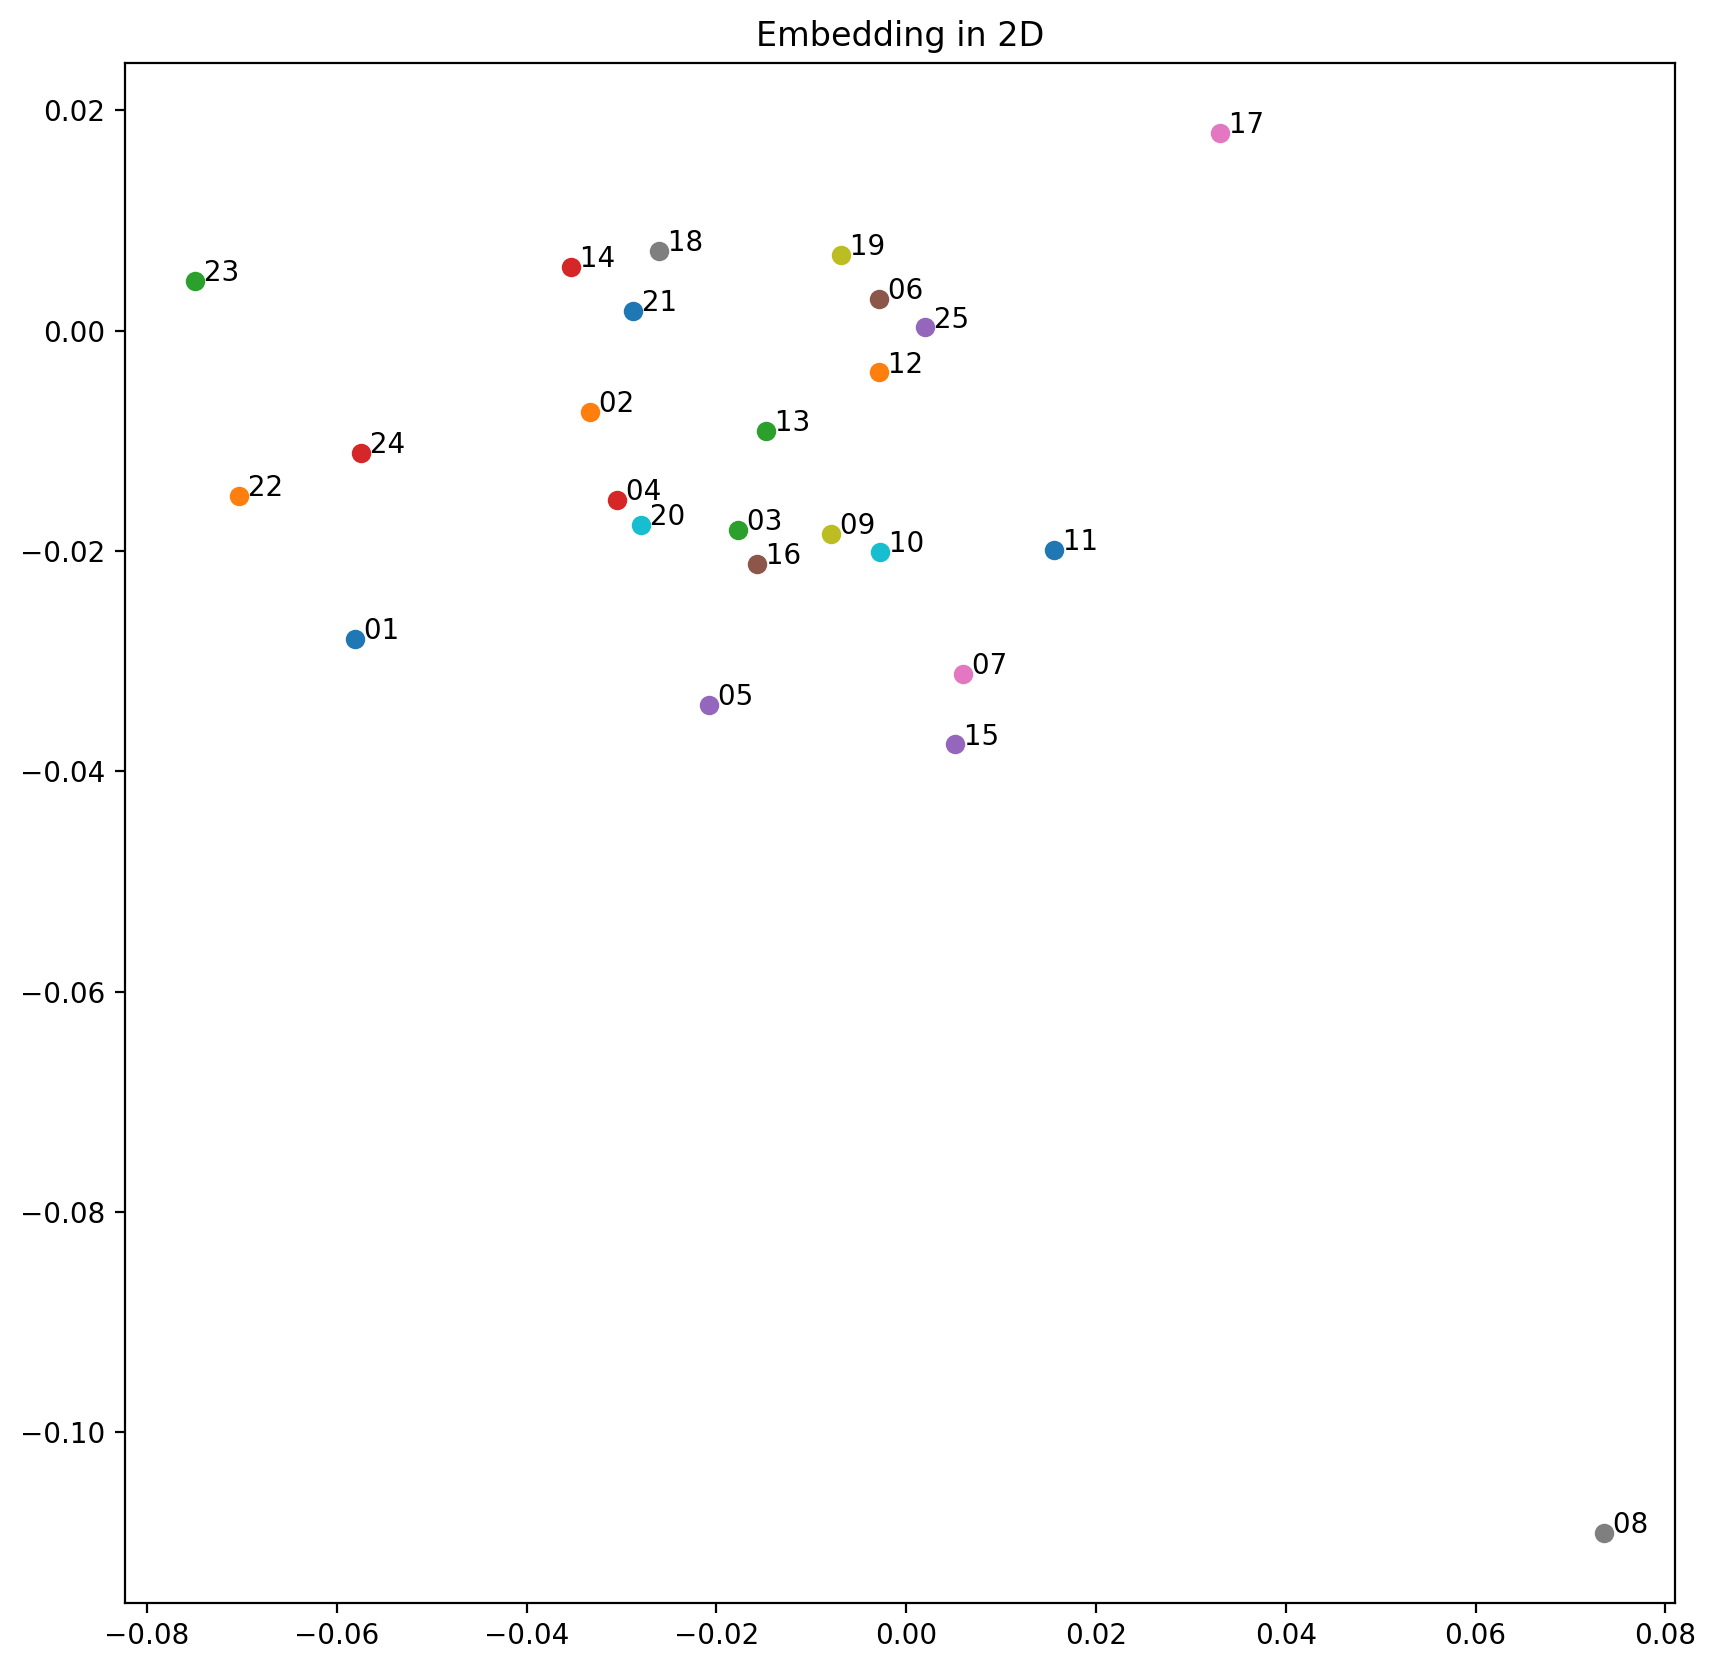

In [ ]:
# PCA for getting 2D vectors
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(feature_df.drop(columns="id"))

# Visualizing
plt.figure(figsize=(10, 10), dpi=200)
for idx, document_id in enumerate(feature_df.iloc[0:25]["id"].to_list()):
    x, y = reduced_embeddings[idx]
    plt.scatter(x, y)
    plt.annotate(f"{document_id: 03}", xy=(x, y), fontsize=10)
plt.title("Embedding in 2D")
plt.show()